## Neural Network vs. Equivariant Neural Network

Author: Roy Forestano

Date: 8 June 2023

Failed attempt to implment formalism described in:
- What is an equivariant neural network?: https://arxiv.org/abs/2205.07362

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import scipy
import os
import copy
from tqdm import tqdm
from time import time
import itertools

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
torch.set_default_dtype(torch.float64)
plt.rcParams["font.family"] = 'sans-serif'
np.set_printoptions(formatter={'float_kind':'{:f}'.format}) 

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [113]:
# Define model
class classifier(nn.Module):
    def __init__(self,n_dim): #n_dim
        super(classifier,self).__init__() 
       
        self.network = nn.Sequential( nn.Linear(in_features = 2, out_features = 3, bias = False),
                                       nn.ReLU(),
                                       nn.Linear(in_features = 3, out_features = 3, bias =False),
                                       nn.ReLU(),
                                       nn.Linear(in_features = 3, out_features = 2, bias = False) )

#         self.make_between_01 = nn.Sigmoid()
        self.rescale = nn.Softmax(dim=1)
        self.n_dim = n_dim

    def forward(self, x):
        classification = self.network(x).reshape(x.shape[0],2)
#         classification = self.make_between_01(x)
        classification = self.rescale(classification)
        weights = []
#         weights = [ param.detach() for param in self.network.parameters() if len(param.shape)>1  ]
        for i,param in enumerate(self.network.parameters()):
            if len(param.shape)>1:
                weights.append( param )
        
        return classification, weights #,biases

In [114]:
def bracket(A,B):
    return A@B-B@A

def modified_brackets_sum(A,B_list):
    for i,symmetry_representation in enumerate(B_list):
        if symmetry_representation[0].shape[0]==A.shape[0]:      
            C = symmetry_representation
        if symmetry_representation[0].shape[0]==A.shape[1]:
            D = symmetry_representation
    total_bracket_sum = 0.
    for i,Dreps in enumerate(zip(C,D)):
        Ci = Dreps[0]
        Di = Dreps[1]
        total_bracket_sum += (Ci@A-A@Di).abs().sum()
    return total_bracket_sum

def accuracy(pred,true,size):
    return (pred.argmax(dim=1).reshape(true.shape[0],1)==true.reshape(true.shape[0],1)).sum()/size

loss_classfn = torch.nn.CrossEntropyLoss()
def loss_fn(pred,true,weights,symmetry_matrix,epoch): #,biases):
    loss_class   = loss_classfn(pred,true)
    return loss_class

def loss_fn_equi(pred,true,weights,symmetry_matrices,epoch): #,biases):
    loss_class   = loss_classfn(pred,true)
    loss_equi    = torch.stack([ modified_brackets_sum(A,symmetry_matrices) for A in weights],dim=0).sum()/len(weights)
#     if epoch<300:
#         return loss_equi
#     else:
    return loss_class+loss_equi

In [115]:
def train(data,
          val_data,
          labels,
          val_labels,
          model, 
          loss_fn, 
          epochs, 
          optimizer):
    
    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []} 
    
    best_val_loss = torch.inf
    start = time()
    
    train_x = data.reshape(data.shape[0],data.shape[1]).to(device)
    train_y = labels.reshape(labels.shape[0],).to(device).type(torch.LongTensor)
    val_x = val_data.reshape(val_data.shape[0],val_data.shape[1]).to(device)
    val_y = val_labels.reshape(val_labels.shape[0],).to(device).type(torch.LongTensor)
    
    train_size = train_y.shape[0]
    val_size = val_y.shape[0]
    
    for i in range(epochs):
        train_loss = 0.
        model.train()
        train_predictions,weights = model(train_x) #,biases
        loss = loss_fn(train_predictions,train_y,weights,symmetry_matrices,epoch=i)#,biases)
        train_acc = accuracy(train_predictions,train_y,train_size)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        
        model.eval()
        with torch.no_grad():
            val_predictions,weights = model(val_x)
            val_loss = loss_fn(val_predictions,val_y,weights,symmetry_matrices,epoch=i).detach() #,biases)
            val_acc = accuracy(val_predictions,val_y,val_size)
            
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if i%100==0:
            print(f"Epoch {i+1}  | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.5f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc:.5f}")
        if (i+1)==epochs:
            print(f"Epoch {i+1}  | Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.5f} | Val Loss: {val_loss:.5f} | Val Acc: {val_acc:.5f}")
        
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(),'simple_equivariant.pth')
            
        if train_loss*1e25 < 1:
            print()
            print('Reached Near Machine Zero')
            break
    
    end = time()
    total_time = end-start
    print(f'Total Time: {total_time:>.8f}')
    return {'history': history}

## Define Datasets

In [116]:
np.random.seed(0)
dsize = 125
s=-0.999 #0.001
l=-0.001 #0.999
s1=0.001 #1.001
l1=1 #2
square2 = np.random.uniform(s, l, dsize) + 1.j * np.random.uniform(s, l, dsize)
square1 = np.random.uniform(s1, l1, dsize) + 1.j * np.random.uniform(s, l, dsize)
square3 = np.random.uniform(s, l, dsize) + 1.j * np.random.uniform(s1, l1, dsize)
square4 = np.random.uniform(s1, l1, dsize) + 1.j * np.random.uniform(s1, l1, dsize)
squares = [square2,square4,square1,square3]
coordinates = np.zeros((dsize*len(squares),2))
labels = np.zeros(((dsize*len(squares),1)))
for i,square in enumerate(squares):
    for j,point in enumerate(square):
        coordinates[i*dsize+j,:] = np.array([point.real,point.imag])
        if i==0:
                labels[i*dsize+j] = np.array([0])
        elif i==1:
                labels[i*dsize+j] = np.array([1])
        elif i==2:
#             if np.abs(point.real-1)<=1-np.abs(point.imag):
            if np.abs(point.real)>=np.abs(point.imag):
                labels[i*dsize+j] = np.array([0])
            else:
                labels[i*dsize+j] = np.array([1])
        elif i==3:
            if np.abs(point.real)>=np.abs(point.imag):
#             if np.abs(point.real)>=1-np.abs(point.imag-1):
                labels[i*dsize+j] = np.array([1])
            else:
                labels[i*dsize+j] = np.array([0])
            
reflect = np.array([[0 ,1],
                    [1,0]]).reshape(2,2)
add_coordinates = np.transpose(reflect@np.transpose(coordinates))
add_labels = copy.copy(labels)
data_type1 = np.vstack([coordinates,add_coordinates])
labels_type1 = np.vstack([labels,add_labels])

Text(0.5, 1.0, 'Data with Labels')

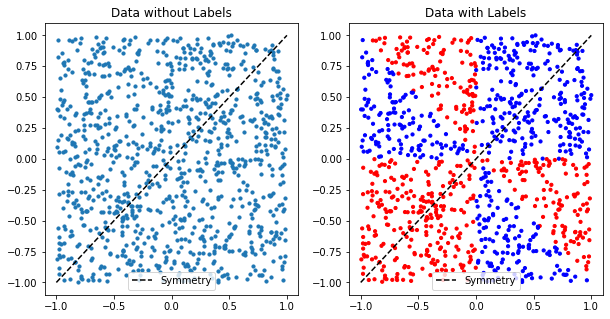

In [117]:
plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(-1,1,100),np.linspace(-1,1,100),linestyle='--',c='black',label='Symmetry',)
plt.scatter(data_type1[:,0],data_type1[:,1],s=10)
plt.legend()
plt.title('Data without Labels')
plt.subplot(1,2,2)
plt.plot(np.linspace(-1,1,100),np.linspace(-1,1,100),linestyle='--',c='black',label='Symmetry')
plt.scatter(data_type1[:,0],data_type1[:,1],c=labels_type1,s=10,cmap=mpl.colors.ListedColormap(['red','blue']) )
plt.legend()
plt.title('Data with Labels')

In [118]:
data_type1.shape[0]

1000

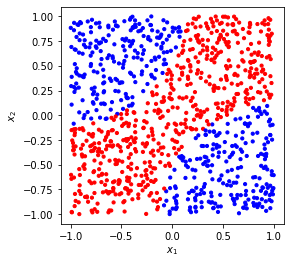

In [119]:
np.random.seed(0)
def Data_generate(samples, center=[[-1.0, 1.0],[1.0, -1.0]], radius=1.1):
    """
    Generates a dataset of points with 1/0 labels.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center[0]) < radius or np.linalg.norm(x - center[1]) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)

def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    plt.scatter(x[:, 0], x[:, 1],  c=y, cmap=mpl.colors.ListedColormap(['red','blue']), s=10)#), edgecolor="k")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
               
data_type2, labels_type2 = Data_generate(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(data_type2, labels_type2, fig=fig, ax=ax)
plt.show()

In [120]:
data_type2.shape[0]

1000

(-1.6036805246359829,
 1.6246986291780772,
 -1.6290846085899637,
 1.6172530498641284)

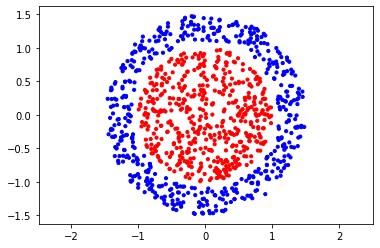

In [121]:
np.random.seed(0)
radius = 1
center = np.array([0,0])
dsize=2588
data_cont=np.random.uniform(-2, 2, size=(dsize,2))
class1 = data_cont[np.where(np.linalg.norm(data_cont,axis=1) < radius)]
class2 = data_cont[np.logical_and(np.linalg.norm(data_cont,axis=1) > (radius+0.1),np.linalg.norm(data_cont,axis=1) < (radius+0.493) ) ]
total_size = class1.shape[0]+class2.shape[0]
coord_cont = np.vstack([class1,class2]).reshape(total_size,2)
labels_cont = np.zeros(class1.shape[0]+class2.shape[0],dtype='int32').reshape(class1.shape[0]+class2.shape[0],1)
labels_cont[class1.shape[0]:]=1
all_cont_data = np.hstack([coord_cont,labels_cont]).reshape(class1.shape[0]+class2.shape[0],3)
np.random.shuffle(all_cont_data)

data_type3 = copy.deepcopy(all_cont_data)[:,:2]
labels_type3 = copy.deepcopy(all_cont_data)[:,2]

plt.scatter(data_type3[:,0],data_type3[:,1],c=labels_type3,s=10,cmap=mpl.colors.ListedColormap(['red','blue']))
plt.axis('equal')

In [122]:
data_type3.shape[0]

1000

In [123]:
class1.shape[0]-class2.shape[0]

0

In [124]:
torch.linalg.inv(torch.tensor([[0.,1.],
                               [1.,0.]]).reshape(2,2))

tensor([[-0., 1.],
        [1., 0.]])

In [208]:
from sklearn.model_selection import train_test_split

data_type1 = torch.tensor( copy.deepcopy(data_type1) )
labels_type1 = torch.tensor( copy.deepcopy(labels_type1) )

data_type2 = torch.tensor( copy.deepcopy(data_type2) )
labels_type2 = torch.tensor( copy.deepcopy(labels_type2) )

data_type3 = torch.tensor( copy.deepcopy(data_type3) )
labels_type3 = torch.tensor( copy.deepcopy(labels_type3) )

# Set up training and validation data tensors
x1_train, x1_val, y1_train, y1_val = train_test_split(data_type1, 
                                                        labels_type1, 
                                                        test_size=0.50,
                                                        random_state=0)

x2_train, x2_val, y2_train, y2_val = train_test_split(data_type2, 
                                                        labels_type2, 
                                                        test_size=0.50,
                                                        random_state=0)

x3_train, x3_val, y3_train, y3_val = train_test_split(data_type3, 
                                                        labels_type3, 
                                                        test_size=0.50,
                                                        random_state=0)

<ipython-input-208-3aa4e874faa4>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_type1 = torch.tensor( copy.deepcopy(data_type1) )
<ipython-input-208-3aa4e874faa4>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_type1 = torch.tensor( copy.deepcopy(labels_type1) )
<ipython-input-208-3aa4e874faa4>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_type2 = torch.tensor( copy.deepcopy(data_type2) )
<ipython-input-208-3aa4e874faa4>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().d

## Set Up Training Sets

---
## Traditional Network

In [134]:
fourD_rep = torch.linalg.inv(torch.tensor([[0.,1.,0.,0.],
                                            [1.,0.,0.,0.],
                                            [0.,0.,1.,0.],
                                            [0.,0.,0.,1.] ]).reshape(4,4) )

threeD_rep = torch.linalg.inv(torch.tensor([[0.,1.,0.],
                                            [1.,0.,0.],
                                            [0.,0.,1.] ]).reshape(3,3) )

twoD_rep = torch.linalg.inv(torch.tensor([ [0.,1.],
                                           [1.,0.] ]).reshape(2,2) )

In [135]:
m21 = torch.linalg.inv(torch.tensor([ [0.,1.],
                                      [-1.,0.] ] ).reshape(2,2) )

m22 = torch.linalg.inv(torch.tensor([ [0.,-1.],
                                      [1.,0.] ]).reshape(2,2) )

m23 = torch.linalg.inv(torch.tensor([ [0.,1.],
                                      [1.,0.] ]).reshape(2,2) )

m24 = torch.linalg.inv(torch.tensor([ [1.,0.],
                                      [0.,1.] ]).reshape(2,2) )

m25 = torch.linalg.inv(torch.tensor([ [-1.,0.],
                                      [0.,1.] ]).reshape(2,2) )

m26 = torch.linalg.inv(torch.tensor([ [0.,-1.],
                                      [-1.,0.] ]).reshape(2,2) )

m27 = torch.linalg.inv(torch.tensor([ [1.,0.],
                                      [0.,-1.] ]).reshape(2,2) )

m28 = torch.linalg.inv(torch.tensor([ [-1.,0.],
                                      [0.,-1.] ]).reshape(2,2) )

In [136]:
m31 = torch.linalg.inv(torch.tensor([[0.,1.,0.],
                                     [-1.,0.,0.],
                                     [0.,0.,1.] ]).reshape(3,3) )

m32 = torch.linalg.inv(torch.tensor([[0.,-1.,0.],
                                     [1.,0.,0.],
                                     [0.,0.,1.] ]).reshape(3,3) )

m33 = torch.linalg.inv(torch.tensor([[0.,1.,0.],
                                     [1.,0.,0.],
                                     [0.,0.,1.] ]).reshape(3,3) )

m34 = torch.linalg.inv(torch.tensor([[1.,0.,0.],
                                     [0.,1.,0.],
                                     [0.,0.,1.] ]).reshape(3,3) )

m35 = torch.linalg.inv(torch.tensor([[-1.,0.,0.],
                                     [0.,1.,0.],
                                     [0.,0.,1.] ]).reshape(3,3) )

m36 = torch.linalg.inv(torch.tensor([[0.,-1.,0.],
                                     [-1.,0.,0.],
                                     [0.,0.,1.] ]).reshape(3,3) )

m37 = torch.linalg.inv(torch.tensor([[1.,0.,0.],
                                     [0.,-1.,0.],
                                     [0.,0.,1.] ]).reshape(3,3) )

m38 = torch.linalg.inv(torch.tensor([[-1.,0.,0.],
                                     [0.,-1.,0.],
                                     [0.,0.,1.] ]).reshape(3,3) )

In [189]:
# symmetry_matrices = [ [m21,m22,m23,m24,m25,m26,m27,m28] , [m31,m32,m33,m34,m35,m36,m37,m38] ]#, [fourD_rep] ]
# symmetry_matrices = [ [m21,m23], [m31,m33]]
# symmetry_matrices = [ [m23], [m33]]
symmetry_matrices = [ [m23,m24,m26,m28] , [m33,m34,m36,m38] ]

## Set Hyperparameters and Train the Model

In [138]:
torch.manual_seed(0)
n_samples  = x2_train.shape[0] # sample size
n_dim      = x2_train.shape[1]   # dimension = coordinate points*2 - label column

lr = 1e-3
model = classifier(n_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = loss_fn
print(model)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

classifier(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=False)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=3, bias=False)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=2, bias=False)
  )
  (rescale): Softmax(dim=1)
)


In [139]:
n_samples

600

In [140]:
n_dim

2

In [141]:
epochs = 2000

training = train( data             = x2_train,
                  val_data         = x2_val,
                  labels           = y2_train,
                  val_labels       = y2_val,
                  model            = model, 
                  loss_fn          = loss_fn,
                  epochs           = epochs,
                  optimizer        = optimizer)

Epoch 1  | Train Loss: 0.69313 | Train Acc: 0.73167 | Val Loss: 0.69313 | Val Acc: 0.69750
Epoch 101  | Train Loss: 0.69104 | Train Acc: 0.65000 | Val Loss: 0.69163 | Val Acc: 0.62750
Epoch 201  | Train Loss: 0.68057 | Train Acc: 0.62667 | Val Loss: 0.68405 | Val Acc: 0.60500
Epoch 301  | Train Loss: 0.66054 | Train Acc: 0.62333 | Val Loss: 0.66936 | Val Acc: 0.59000
Epoch 401  | Train Loss: 0.64518 | Train Acc: 0.63333 | Val Loss: 0.65782 | Val Acc: 0.59500
Epoch 501  | Train Loss: 0.63760 | Train Acc: 0.64667 | Val Loss: 0.65179 | Val Acc: 0.62000
Epoch 601  | Train Loss: 0.63279 | Train Acc: 0.66333 | Val Loss: 0.64809 | Val Acc: 0.64750
Epoch 701  | Train Loss: 0.62921 | Train Acc: 0.67500 | Val Loss: 0.64537 | Val Acc: 0.66000
Epoch 801  | Train Loss: 0.62659 | Train Acc: 0.68833 | Val Loss: 0.64334 | Val Acc: 0.66750
Epoch 901  | Train Loss: 0.62471 | Train Acc: 0.70333 | Val Loss: 0.64180 | Val Acc: 0.67250
Epoch 1001  | Train Loss: 0.62344 | Train Acc: 0.70667 | Val Loss: 0.640

In [142]:
#model.load_state_dict(torch.load('best_SO4.pth',map_location=torch.device('cpu')))

## Visualize the History of Training Loss

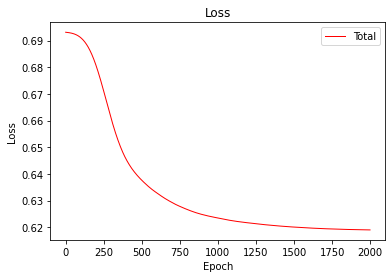

In [143]:
train_loss = np.array(training['history']['train_loss'])
N=train_loss.shape[0]
plt.figure(figsize=(6,4)) #, dpi=100)
plt.plot(train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title('Loss')
plt.show()

## Extract Results

In [144]:
model.eval()

with torch.no_grad():
    classify_new_shapes,weights = model(x2_val)

classification1 = classify_new_shapes.argmax(dim=1)

In [145]:
classify_new_shapes[:5]

tensor([[5.0000e-01, 5.0000e-01],
        [6.3097e-04, 9.9937e-01],
        [5.0000e-01, 5.0000e-01],
        [5.0000e-01, 5.0000e-01],
        [5.0000e-01, 5.0000e-01]])

In [146]:
accuracy(classify_new_shapes,y2_val,y2_val.shape[0])

tensor(0.6975)

In [147]:
y2_val.shape

torch.Size([400])

In [148]:
model.eval()

with torch.no_grad():
    classify_new_shapes12,weights = model(torch.tensor([-0.75,0.6]).reshape(1,2))

In [149]:
classify_new_shapes12

tensor([[4.5915e-04, 9.9954e-01]])

Text(0.5, 1.0, 'Validation Predictions')

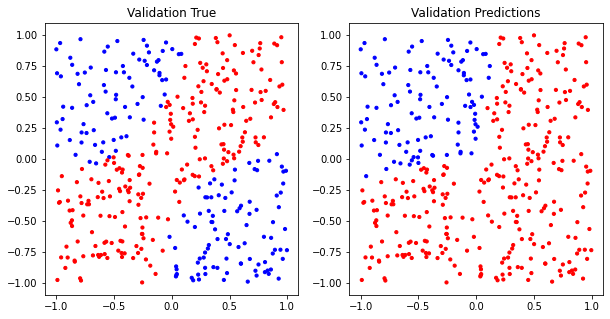

In [150]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x2_val[:,0].detach().numpy(),x2_val[:,1].detach().numpy(),c=y2_val.detach().numpy(),s=10,cmap=mpl.colors.ListedColormap(['red','blue']))
plt.title('Validation True')
plt.subplot(1,2,2)
plt.scatter(x2_val[:,0].detach().numpy(),x2_val[:,1].detach().numpy(),c=classification1.detach().numpy(),s=10,cmap=mpl.colors.ListedColormap(['red','blue']) )
plt.title('Validation Predictions')

In [151]:
# # plot data
# plt.subplots(1,3,figsize=(16,5))
# plt.subplot(1,3,1)
# plt.scatter(coordinates[:,0],coordinates[:,1],c=labels,s=10)
# plt.title('Original Data')
# plt.subplot(1,3,2)

# cm = plt.cm.RdBu

# # make data for decision regions
# xx, yy = np.meshgrid(np.linspace(s, l1, 20), np.linspace(s, l1, 20))
# X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
# # preprocess grid points like data inputs above
# padding = 0.3 * np.ones((len(X_grid), 1))
# X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
# normalization = np.sqrt(np.sum(X_grid ** 2, -1))
# X_grid = (X_grid.T / normalization).T  # normalize each input
# features_grid = np.array([get_angles(x) for x in X_grid])  # angles for state preparation are new features
# predictions_grid = [vqnn(weights, bias, f) for f in features_grid]
# Z = np.reshape(predictions_grid, xx.shape)

# # plot decision regions
# cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1, 0.2), cmap=cm, alpha=0.8, extend="both")
# plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
# plt.colorbar(cnt, ticks=[-1, 0, 1])

# plt.scatter(
#     X_train[(Y_train == 1).reshape(Y_train.shape[0],),0],
#     X_train[(Y_train == 1).reshape(Y_train.shape[0],),1],
#     c="purple",
#     marker="o",
#     edgecolors="k",
#     label="class 1 train",
# )
# plt.scatter(
#     X_val[(Y_val == 1).reshape(Y_val.shape[0],),0],
#     X_val[(Y_val == 1).reshape(Y_val.shape[0],),1],
#     c="blue",
#     marker="^",
#     edgecolors="k",
#     label="class 1 validation",
# )
# plt.scatter(
#     X_train[(Y_train == -1).reshape(Y_train.shape[0],),0],
#     X_train[(Y_train == -1).reshape(Y_train.shape[0],),1],
#     c="orange",
#     marker="o",
#     edgecolors="k",
#     label="class -1 train",
# )
# plt.scatter(
#     X_val[(Y_val == -1).reshape(Y_val.shape[0],),0],
#     X_val[(Y_val == -1).reshape(Y_val.shape[0],),1],
#     c="yellow",
#     marker="^",
#     edgecolors="k",
#     label="class -1 validation",
# )
# plt.title('Predicted Contours')
# plt.legend()

# plt.subplot(1,3,3)
# predictions_now = [int(np.sign(vqnn(weights, bias, f)).item()) for f in features]
# for i in range(len(predictions_now)):
#     if predictions_now[i]==-1:
#         plt.scatter(X[i,0].item(),X[i,1].item(),c='gold',s=10)
#     else:
#         plt.scatter(X[i,0].item(),X[i,1].item(),c='purple',s=10)
# plt.title('Predicitons')
# plt.show()

---
## Equivariant Network


In [152]:
symmetry_matrix = torch.linalg.inv(torch.tensor([[0.,1.],[1.,0.]]).reshape(2,2))

## Set Hyperparameters and Train the Model

In [190]:
torch.manual_seed(0)
n_samples  = x2_train.shape[0] # sample size
n_dim      = x2_train.shape[1]   # dimension = coordinate points*2 - label column

lr = 1e-3
model = classifier(n_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = loss_fn_equi
print(model)
print('------------------')
for param in model.parameters():
    print(param.detach().shape)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

classifier(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=False)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=3, bias=False)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=2, bias=False)
  )
  (rescale): Softmax(dim=1)
)
------------------
torch.Size([3, 2])
torch.Size([3, 3])
torch.Size([2, 3])


In [191]:
n_samples

600

In [192]:
n_dim

2

In [193]:
epochs = 2000

training = train( data             = x2_train,
                  val_data         = x2_val,
                  labels           = y2_train,
                  val_labels       = y2_val,
                  model            = model, 
                  loss_fn          = loss_fn,
                  epochs           = epochs,
                  optimizer        = optimizer)

Epoch 1  | Train Loss: 2.35490 | Train Acc: 0.73167 | Val Loss: 2.34157 | Val Acc: 0.70250
Epoch 101  | Train Loss: 1.32308 | Train Acc: 0.72500 | Val Loss: 1.31378 | Val Acc: 0.56750
Epoch 201  | Train Loss: 0.74072 | Train Acc: 0.54167 | Val Loss: 0.74099 | Val Acc: 0.56750
Epoch 301  | Train Loss: 0.69416 | Train Acc: 0.54167 | Val Loss: 0.69417 | Val Acc: 0.56750
Epoch 401  | Train Loss: 0.69380 | Train Acc: 0.54167 | Val Loss: 0.69417 | Val Acc: 0.56750
Epoch 501  | Train Loss: 0.69408 | Train Acc: 0.54167 | Val Loss: 0.69418 | Val Acc: 0.56750
Epoch 601  | Train Loss: 0.69455 | Train Acc: 0.54167 | Val Loss: 0.69451 | Val Acc: 0.56750
Epoch 701  | Train Loss: 0.69402 | Train Acc: 0.54167 | Val Loss: 0.69457 | Val Acc: 0.56750
Epoch 801  | Train Loss: 0.69499 | Train Acc: 0.54167 | Val Loss: 0.69519 | Val Acc: 0.56750
Epoch 901  | Train Loss: 0.69416 | Train Acc: 0.54167 | Val Loss: 0.69401 | Val Acc: 0.56750
Epoch 1001  | Train Loss: 0.69425 | Train Acc: 0.54167 | Val Loss: 0.694

In [194]:
#model.load_state_dict(torch.load('best_SO4.pth',map_location=torch.device('cpu')))

## Visualize the History of Training Loss

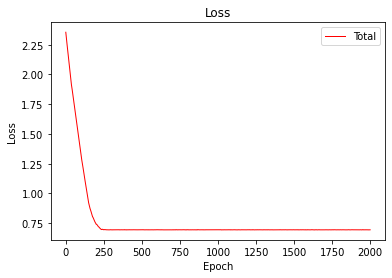

In [195]:
train_loss = np.array(training['history']['train_loss'])
N=train_loss.shape[0]
plt.figure(figsize=(6,4)) #, dpi=100)
plt.plot(train_loss[:N], linewidth=1, linestyle='-',  color = 'r', label='Total')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title('Loss')
plt.show()

## Extract Results

In [196]:
model.eval()

with torch.no_grad():
    classify_new_shapes2,weights = model(x2_val)

classification2 = classify_new_shapes2.argmax(dim=1)

In [197]:
classify_new_shapes2[:5]

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]])

In [198]:
y2_val[:5]

tensor([0, 1, 0, 1, 0])

In [199]:
accuracy(classify_new_shapes2,y2_val,y2_val.shape[0])

tensor(0.5675)

In [200]:
y2_val.shape

torch.Size([400])

In [201]:
# model.eval()

# with torch.no_grad():
#     classify_new_shapes3,weights = model(torch.tensor([0.5818,-0.4]).reshape(1,2))

In [202]:
# classify_new_shapes3

In [203]:
# model.eval()

# with torch.no_grad():
#     classify_new_shapes4,weights = model(torch.tensor([0.7,-0.8]).reshape(1,2))

In [204]:
# classify_new_shapes4[0]

In [205]:
# x2_val[0]

In [206]:
# y2_val[0]

Text(0.5, 1.0, 'Validation Predictions')

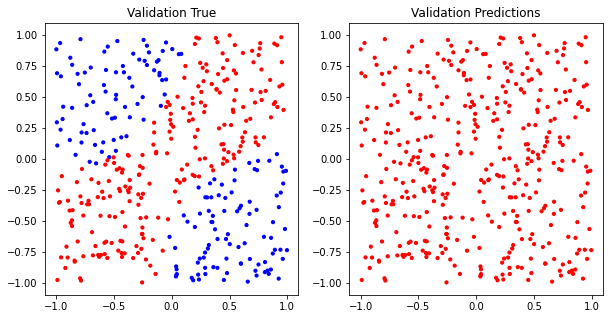

In [207]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(x2_val[:,0].detach().numpy(),x2_val[:,1].detach().numpy(),c=y2_val.detach().numpy(),s=10,cmap=mpl.colors.ListedColormap(['red','blue']))
plt.title('Validation True')
plt.subplot(1,2,2)
plt.scatter(x2_val[:,0].detach().numpy(),x2_val[:,1].detach().numpy(),c=classification2.detach().numpy(),s=10,cmap=mpl.colors.ListedColormap(['red','blue']) )
plt.title('Validation Predictions')

## Goals and Comments

- How the equivariance is interacting with the activation function used
- Improve on the classical equivariance case
- Modify a quantum version with the same number of parameters, corresponding number of qubits/gates, and train/test split
- Equivariance used where? Complicated to incorporate throughout the entire model. Latent space? Input layers? Output Layers?